In [18]:
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.spatial.transform import Rotation
from scipy.sparse import dia_matrix

from qutip import sigmax, sigmay, sigmaz, jmat

%matplotlib widget

from labellines import labelLine, labelLines

In [19]:
# Coupling formula
mu_0 = 12.5663706127e-7 # r^3/T^2/J
h = 6.62607015e-34 # J/s
gamma_w = 1.1282407e7 * h/2/np.pi # J/T
alpha_w = mu_0/4/np.pi * (gamma_w)**2 # J.r^3
gamma_ratio = 1.1282407/6.567400
gamma_nb = gamma_w / gamma_ratio # J/T

# https://doi.org/10.1063/1.1725143
a = 5.243e-10 # In meters
c = 11.376e-10 # In meters
# Lattice parameters:
lattice_x = np.array([a, 0, 0])
lattice_y = np.array([0, a, 0])
lattice_z = np.array([0, 0, c])

lattice_s = np.array([[a, a, c]]) * np.array([
    [0.5,0.5,0],
    [0.5,0,0.25],
    [0,0,0.5],
    [0,0.5,0.75],
])

site_nb = lattice_s.shape[0]


@vectorize([float64(float64,float64,float64)])
def compute_spatial_coupling(x, y, z):
    norm = (x**2 + y**2 + z**2)**0.5
    return alpha_w/norm**3*(1-3*z**2/norm**2)/h

@vectorize([float64(int64, int64, int64, int64, int64)])
def compute_coupling(x, y, z, a, b):
    vec = x*lattice_x + y*lattice_y + z*lattice_z + lattice_s[a] - lattice_s[b]
    return compute_spatial_coupling(vec[0], vec[1],  vec[2])

@jit
def couplings(sites):
    n = sites.shape[0]
    couplings = np.full((n , n), np.nan)
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            couplings[i, j] = compute_coupling(x, y, z, sites[i][3], sites[j][3])
    return couplings

@jit
def spatial_couplings(sites):
    full_sites = sites[None,:,:] - sites[:,None,:]
    couplings = compute_spatial_coupling(full_sites[:,:,0], full_sites[:,:,1], full_sites[:,:,2])
    for i in range(couplings.shape[0]):
        for j in range(0, i):
            couplings[i,j] = np.nan
    return couplings



In [20]:
# Label

def first_cell_label(s):
    if s[2] == 1:
        letter = "E"
    else:
        match (s[0], s[1]):
            case (0,0):
                letter = "A"
            case (1,0):
                letter = "B"
            case (0,1):
                letter = "D"
            case (1,1):
                letter = "C"
            case _:
                raise ValueError("Not in first cell")
    match s[3]:
        case 0:
            site = "III"
        case 1:
            site = "II"
        case 2:
            site = "I"
        case 3:
            site = "II'"
    return f"{site}-{letter}"
            

## Generate theoretical couplings

In [21]:
first_cell_sites = np.unique(np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [0,1,0,1],
    [1,0,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2]
]), axis = 0)

cell_sites = np.unique(np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [0,1,0,1],
    [1,0,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2],

    [1,0,0,0],
    [1,0,0,1],
    [1,0,0,2],
    [1,0,0,3],
    [1,0,1,0],
    [1,1,0,1],
    [2,0,0,3],
    [2,0,0,2],
    [1,1,0,2],
    [2,1,0,2],

    [0,1,0,0],
    [0,1,0,1],
    [0,1,0,2],
    [0,1,0,3],
    [0,1,1,0],
    [0,2,0,1],
    [1,1,0,3],
    [1,1,0,2],
    [0,2,0,2],
    [1,2,0,2],

    [1,1,0,0],
    [1,1,0,1],
    [1,1,0,2],
    [1,1,0,3],
    [1,1,1,0],
    [1,2,0,1],
    [2,1,0,3],
    [2,1,0,2],
    [1,2,0,2],
    [2,2,0,2],
]), axis=0)


eight_cell_sites = np.unique(np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [0,1,0,1],
    [1,0,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2],

    [1,0,0,0],
    [1,0,0,1],
    [1,0,0,2],
    [1,0,0,3],
    [1,0,1,0],
    [1,1,0,1],
    [2,0,0,3],
    [2,0,0,2],
    [1,1,0,2],
    [2,1,0,2],

    [0,1,0,0],
    [0,1,0,1],
    [0,1,0,2],
    [0,1,0,3],
    [0,1,1,0],
    [0,2,0,1],
    [1,1,0,3],
    [1,1,0,2],
    [0,2,0,2],
    [1,2,0,2],

    [1,1,0,0],
    [1,1,0,1],
    [1,1,0,2],
    [1,1,0,3],
    [1,1,1,0],
    [1,2,0,1],
    [2,1,0,3],
    [2,1,0,2],
    [1,2,0,2],
    [2,2,0,2],

    [0,0,1,0],
    [0,0,1,1],
    [0,0,1,2],
    [0,0,1,3],
    [0,0,2,0],
    [0,1,1,1],
    [1,0,1,3],
    [1,0,1,2],
    [0,1,1,2],
    [1,1,1,2],

    [1,0,1,0],
    [1,0,1,1],
    [1,0,1,2],
    [1,0,1,3],
    [1,0,2,0],
    [1,1,1,1],
    [2,0,1,3],
    [2,0,1,2],
    [1,1,1,2],
    [2,1,1,2],

    [0,1,1,0],
    [0,1,1,1],
    [0,1,1,2],
    [0,1,1,3],
    [0,1,2,0],
    [0,2,1,1],
    [1,1,1,3],
    [1,1,1,2],
    [0,2,1,2],
    [1,2,1,2],

    [1,1,1,0],
    [1,1,1,1],
    [1,1,1,2],
    [1,1,1,3],
    [1,1,2,0],
    [1,2,1,1],
    [2,1,1,3],
    [2,1,1,2],
    [1,2,1,2],
    [2,2,1,2],
]), axis=0)

1.4156498484568866e-61

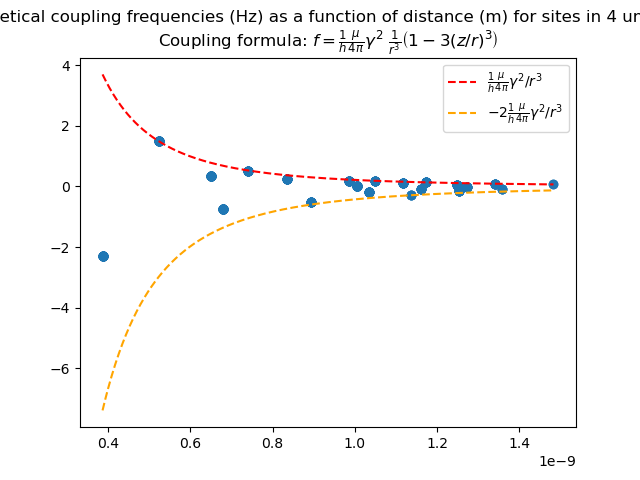

In [22]:
positions = lattice_x[None,:]*cell_sites[:,0][:,None] + lattice_y[None,:] * cell_sites[:,1][:,None] + lattice_z[None,:] * cell_sites[:,2][:,None] + lattice_s[cell_sites[:,3]]

fig, ax = plt.subplots()
fig.suptitle("Theoretical coupling frequencies (Hz) as a function of distance (m) for sites in 4 unit cell")
ax.set_title("Coupling formula: $f = \\frac{1}{h} \\frac{\\mu}{4\\pi} \\gamma^2 \\  \\frac{1}{r^3} \\left(1 - 3\\left(z/r\\right)^3\\right)$")
distances = np.linalg.norm(positions[None,:,:] - positions[:,None,:], axis=2)
couplings_theo = couplings(cell_sites)
ax.scatter(distances, couplings_theo)

x = np.linspace( np.min(distances[~np.isnan(couplings_theo)]), np.max(distances[~np.isnan(couplings_theo)]), 500)
ax.plot(x, alpha_w/h/x**3, "--", label="$\\frac{1}{h} \\frac{\\mu}{4\\pi} \\gamma^2 / r^3$", color="red")
ax.plot(x, -2*alpha_w/h/x**3, "--", label="$-2\\frac{1}{h} \\frac{\\mu}{4\\pi} \\gamma^2 / r^3$", color="orange")
ax.legend()
alpha_w

In [23]:
print("Theoretical couplings in Hz for 4 lattice cell")
pd.DataFrame(couplings(cell_sites))

Theoretical couplings in Hz for 4 lattice cell


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,NaN,-2.296235,-0.754650,-0.523157,-0.290243,1.482382,-2.296235,-0.754650,-0.199927,-0.160277,...,-0.754650,-0.199927,-0.094331,0.166833,0.008353,0.008353,-0.085046,0.008353,-0.035904,0.041431
1,NaN,NaN,-2.296235,-0.754650,-0.523157,0.238546,1.482382,0.330917,0.008353,-0.085046,...,0.330917,0.008353,-0.035904,0.132588,0.123302,0.238546,0.008353,0.166833,0.041431,0.076603
2,NaN,NaN,NaN,-2.296235,-0.754650,0.008353,0.330917,1.482382,0.238546,0.008353,...,0.524101,0.166833,0.041431,0.076603,0.132588,0.185298,0.123302,0.132588,0.076603,0.065513
3,NaN,NaN,NaN,NaN,-2.296235,-0.199927,-0.754650,-2.296235,1.482382,0.330917,...,0.330917,0.524101,0.166833,0.041431,0.166833,0.123302,0.185298,0.123302,0.132588,0.076603
4,NaN,NaN,NaN,NaN,NaN,-0.160277,-0.523157,-0.754650,0.330917,1.482382,...,-0.754650,0.330917,0.524101,-0.035904,0.008353,0.008353,0.238546,0.008353,0.166833,0.041431
5,NaN,NaN,NaN,NaN,NaN,NaN,-2.296235,-0.754650,-0.523157,-0.290243,...,-0.754650,-0.523157,-0.160277,0.330917,-0.754650,0.041431,-0.035904,0.008353,-0.085046,0.008353
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.296235,-0.754650,-0.523157,...,-2.296235,-0.754650,-0.199927,0.524101,0.330917,0.166833,0.008353,0.238546,0.008353,0.166833
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.296235,-0.754650,...,1.482382,0.330917,0.008353,0.166833,0.524101,0.132588,0.123302,0.185298,0.123302,0.132588
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.296235,...,0.330917,1.482382,0.238546,0.008353,0.330917,0.076603,0.132588,0.123302,0.185298,0.123302
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.754650,-2.296235,1.482382,-0.199927,-0.754650,0.041431,0.166833,0.008353,0.238546,0.008353


In [24]:
csv_data = np.genfromtxt("spin_couplings.csv", delimiter=",", filling_values = np.nan)
raw_data = csv_data[1:,1:]

renormalized_data = np.empty(raw_data.shape)


renormalized_data[0] = gamma_ratio * raw_data[0] *2

for i in range(1,renormalized_data.shape[0]):
    renormalized_data[i] = raw_data[i]*2

print("Measured couplings from Will")
pd.DataFrame(renormalized_data, columns=csv_data[0,1:])

Measured couplings from Will


,0.000,807.400,795.200,794.700,797.435,797.675,797.700,796.180,801.200,817.300
0,NaN,-0.696453,-0.188286,0.484803,-0.175574,0.519162,-0.090364,0.542182,-0.164922,-0.336373
1,NaN,NaN,2.706000,0.866000,-4.418000,0.862000,1.244000,-0.404000,-1.058000,-2.350000
2,NaN,NaN,NaN,-0.270000,0.482000,-0.154000,-2.714000,NaN,NaN,0.810000
3,NaN,NaN,NaN,NaN,-0.222000,NaN,-0.154000,0.152000,NaN,-0.154000
4,NaN,NaN,NaN,NaN,NaN,NaN,0.264000,NaN,0.640000,1.444000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exact diagonalization

In [25]:
mu_B = 9.2740094980e-24 # J/T

erbium_gamma = -mu_B * np.array((8.38,8.38, 1.247)) # J/T

erbium_gamma, gamma_w

(array([-7.77161996e-23, -7.77161996e-23, -1.15646898e-23]),
 1.189810845741372e-27)

In [26]:
# Let's look at the hamiltonian...

# First some boilerplate
def get_full_H_matrices(spin, pre_dim, post_dim):
    """
    Construct full spin operator matrices (Sx, Sy, Sz) embedded in a larger Hilbert space.

    This function generates the spin operators Sx, Sy, and Sz for a given spin value,
    and embeds them into a larger Hilbert space. The embedding 
    places the spin operator between identity matrices of dimension `pre_dim` and `post_dim`, 
    representing dimensions before and after the target spin in a composite system.

    Parameters
    ----------
    spin : float or int
        Spin value of the particle (e.g., 0.5 for spin-1/2, 1 for spin-1).
    
    pre_dim : int
        Dimension of the Hilbert space before the spin operator (e.g., for preceding spins).
    
    post_dim : int
        Dimension of the Hilbert space after the spin operator (e.g., for succeeding spins).

    Returns
    -------
    np.ndarray
        A NumPy array containing the full spin operator matrices [Sx, Sy, Sz], each of shape 
        (`pre_dim` * dim_spin * `post_dim`, `pre_dim` * dim_spin * `post_dim`), where `dim_spin = int(2 * spin + 1)`.
    """
    if pre_dim == 0:
        pre_dim = 1
    if post_dim == 0:
        post_dim = 1
    eye_pre = np.eye(pre_dim)
    eye_post = np.eye(post_dim)
    Ix = jmat(spin, 'x').full()
    Iy = jmat(spin, 'y').full()
    Iz = jmat(spin, 'z').full()
    Sx = np.kron(np.kron(eye_pre, Ix), eye_post)
    Sy = np.kron(np.kron(eye_pre, Iy), eye_post)
    Sz = np.kron(np.kron(eye_pre, Iz), eye_post)
    return np.array([Sx, Sy, Sz])

In [27]:
# Dipolar
def dipolar_hamiltonian(mu_1, mu_2, xyz):
    """
    Computes the full dipole hamiltonian of two nuclear spins magnetic moment
    """
    r = np.linalg.norm(xyz)
    return mu_0/4/np.pi/r**3 * (
        # mu_1 . mu_2
        np.sum([mu_1[i] @ mu_2[i] for i in range(len(mu_1))], axis = 0)
        # -3/r² * (mu_1 . r) (mu_2 . r)
        -3/r**2 * (
            np.sum(xyz[:,None, None]*mu_1, axis=0)
            @
            np.sum(xyz[:,None, None]*mu_2, axis=0)
        )
    )

In [28]:
def get_A_parallel(B_0, theta, phi, cell_sites):
    """ It is not A_parallel"""
    B = B_0 * np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
    B_fixed = B #0.8 * np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])

    mu_S = erbium_gamma[:,None, None,] * get_full_H_matrices(1/2, 0, 2)
    mu_I1 = gamma_w * get_full_H_matrices(1/2, 2, 0)

    
    # Zeeman for each atom in the 8dim Hailtonian
    H_zeeman_erbium = -np.sum(B_fixed[:,None, None] * mu_S, axis=0)
    H_zeeman_I1 = -np.sum(B[:,None, None] * mu_I1, axis=0)
    
    cell_positions = lattice_x[None,:]*cell_sites[:,0][:,None] + lattice_y[None,:] * cell_sites[:,1][:,None] + lattice_z[None,:] * cell_sites[:,2][:,None] + lattice_s[cell_sites[:,3]]
    
    erbium_position = lattice_x * 0.5 + lattice_y * 0.5 + lattice_z * 0.5
    
    full_H_couplings = []
    full_H_positions = []
    full_H_eigv = []
    full_H_sites = []
    
    for i in range(len(cell_sites)):
            H = (
                H_zeeman_erbium + H_zeeman_I1
                + dipolar_hamiltonian(mu_I1, mu_S, cell_positions[i] - erbium_position)
            )
            eig, eigv = np.linalg.eigh(H)
            c = (eig[0] + eig[3] - eig[1] - eig[2])/h
            full_H_couplings.append(c)
            full_H_positions.append(np.array(cell_positions[i]))
            full_H_sites.append(np.array(cell_sites[i]))
            full_H_eigv.append(eigv)
            
    
    return np.array(full_H_couplings), np.array(full_H_positions), np.array(full_H_eigv), np.array(full_H_sites)

In [29]:
def get_energies(B_S, B_I1, B_I2, theta, phi, cell_sites, I2 = 1/2, I2_enhance_gamma = 1, secular_axis = None):
    B = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])

    mu_S = erbium_gamma[:,None, None,] * get_full_H_matrices(1/2, 0, 2 * int(2*I2 + 1))
    if secular_axis is not None:
        mu_S = secular_axis[:,None, None] * mu_S
    mu_I1 = gamma_w * get_full_H_matrices(1/2, 2, int(2*I2+ 1))
    mu_I2 = gamma_w * I2_enhance_gamma * get_full_H_matrices(I2, 4, 0)

    
    # Zeeman for each atom in the 8dim Hailtonian
    H_zeeman_erbium = -np.sum(B_S * B[:,None, None] * mu_S, axis=0)
    H_zeeman_I1 = -np.sum(B_I1 * B[:,None, None] * mu_I1, axis=0)
    H_zeeman_I2 = -np.sum(B_I2 * B[:,None, None] * mu_I2, axis=0)
    
    cell_positions = lattice_x[None,:]*cell_sites[:,0][:,None] + lattice_y[None,:] * cell_sites[:,1][:,None] + lattice_z[None,:] * cell_sites[:,2][:,None] + lattice_s[cell_sites[:,3]]
    
    erbium_position = lattice_x * 0.5 + lattice_y * 0.5 + lattice_z * 0.5
    
    full_H_couplings = []
    full_H_positions = []
    full_H_eigv = []
    full_H_sites = []
    no_erbium_couplings = []
    
    for i in range(len(cell_sites)):
        for j in range(i+1, len(cell_sites)):
            if i == j:
                continue
            H_0 = (
                H_zeeman_erbium + H_zeeman_I1 + H_zeeman_I2
                + dipolar_hamiltonian(mu_I1, mu_I2, cell_positions[i] - cell_positions[j])
            )
            H = (
                H_0
                + dipolar_hamiltonian(mu_I1, mu_S, cell_positions[i] - erbium_position)
                + dipolar_hamiltonian(mu_I2, mu_S, cell_positions[j] - erbium_position)
            )
            eig, eigv = np.linalg.eigh(H)
            c = (eig[0] + eig[3] - eig[1] - eig[2])/h
            full_H_couplings.append(c)
            full_H_positions.append(np.array((cell_positions[i],  
                                              cell_positions[j])))
            full_H_sites.append(np.array((cell_sites[i],  cell_sites[j])))
            full_H_eigv.append(eigv)
            
            eig0, eigv0 = np.linalg.eigh(H_0)
            
            no_erbium_couplings.append((eig0[0] + eig0[3] - eig0[1] - eig0[2])/h)
            
    
    return np.array(full_H_couplings), np.array(full_H_positions), np.array(full_H_eigv), np.array(full_H_sites), np.array(no_erbium_couplings)

In [34]:
# B field misalignment
theta = 1/180*np.pi
phi = 0/180*np.pi


B_0 = 0.45  # T

full_H_couplings, full_H_positions, full_H_eigv, full_H_sites, H_0_couplings = get_energies(B_0, B_0, B_0, theta, phi, cell_sites)

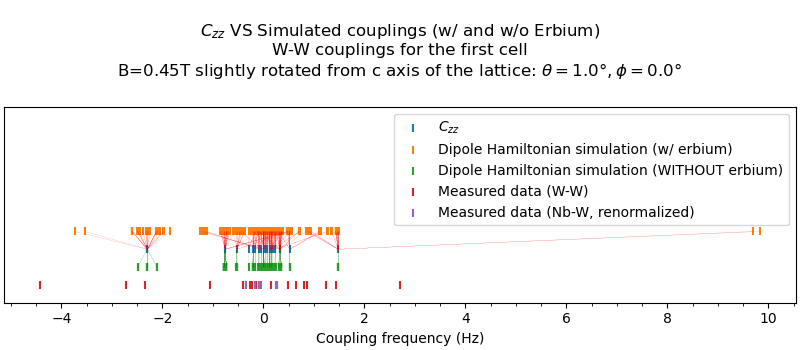

In [35]:
fig, ax = plt.subplots(1,figsize=(8, 3.5), constrained_layout=True)
fig.suptitle(f"""
$C_{{zz}}$ VS Simulated couplings (w/ and w/o Erbium)
W-W couplings for the first cell
B={B_0}T slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")
ax.set_xlabel("Coupling frequency (Hz)")

one_cell_couplings = couplings(cell_sites)

theo_data, inverse = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)], return_inverse = True)
sim_couplings, index = np.unique(full_H_couplings, return_index = True)
sim_couplings_no_er, index_no_er = np.unique(H_0_couplings[~np.isnan(H_0_couplings)], return_index = True)

ax.scatter(theo_data, np.zeros(theo_data.shape), marker = "|", label="$C_{zz}$")
ax.scatter(sim_couplings, np.zeros(sim_couplings.shape)+1, marker = "|", label="Dipole Hamiltonian simulation (w/ erbium)")

ax.scatter(sim_couplings_no_er, np.zeros(sim_couplings_no_er.shape)-1, marker = "|", label="Dipole Hamiltonian simulation (WITHOUT erbium)")


measured_data = (renormalized_data[1:,:])[~np.isnan(renormalized_data[1:,:])]
ax.scatter(measured_data, np.zeros(measured_data.shape)-2, marker = "|", label="Measured data (W-W)")


measured_data = (renormalized_data[0,:])[~np.isnan(renormalized_data[0,:])]/2
ax.scatter(measured_data, np.zeros(measured_data.shape)-2, marker = "|", label="Measured data (Nb-W, renormalized)")

#for i in range(len(full_H_sites)):
    #ax.text(H_0_couplings[i], -2.5, f"{first_cell_label(full_H_sites[i,0])}/{first_cell_label(full_H_sites[i,1])}", size = 7, horizontalalignment='center')


for i, j in enumerate(index):
    ax.plot([theo_data[inverse[j]],sim_couplings[i]], [0,1], linestyle="--", color = "red", linewidth = 0.1)

for i, j in enumerate(index_no_er):
    ax.plot([theo_data[inverse[j]],sim_couplings_no_er[i]], [0,-1], linestyle="--", color = "green", linewidth = 0.1)




ax.set_ylim((-3,8))
ax.legend()
ax.xaxis.grid(True, which='minor')
import matplotlib.ticker as ticker
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.grid(False, which='both')
ax.get_yaxis().set_ticks([])

pass


## Niobium-tungsten

In [32]:
# B field misalignment
theta = 0/180*np.pi
phi = 0/180*np.pi


B_0 = 0.8  # T

full_H_couplings, full_H_positions, full_H_eigv, full_H_sites, H_0_couplings = get_energies(B_0, B_0, B_0, theta, phi, first_cell_sites, I2=9/2, I2_enhance_gamma=1/gamma_ratio)

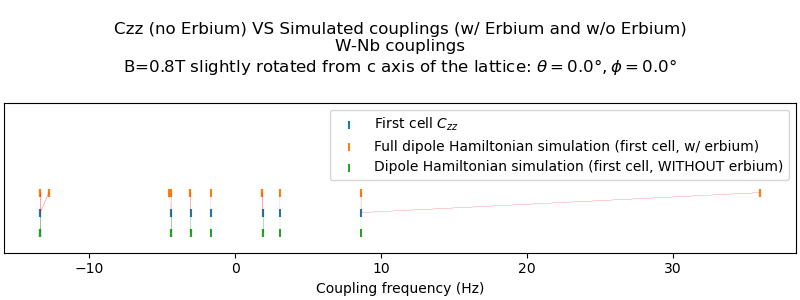

In [33]:
fig, ax = plt.subplots(1,figsize=(8, 3), constrained_layout=True)
fig.suptitle(f"""
Czz (no Erbium) VS Simulated couplings (w/ Erbium and w/o Erbium)
W-Nb couplings
B={B_0}T slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")
ax.set_xlabel("Coupling frequency (Hz)")

one_cell_couplings = couplings(first_cell_sites) / gamma_ratio

theo_data, inverse = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)], return_inverse = True)
sim_couplings, index = np.unique(full_H_couplings[~np.isnan(full_H_couplings)], return_index = True)
sim_couplings_no_er, index_no_er = np.unique(H_0_couplings[~np.isnan(H_0_couplings)], return_index = True)

ax.scatter(theo_data, np.zeros(theo_data.shape), marker = "|", label="First cell $C_{zz}$")
ax.scatter(sim_couplings, np.zeros(sim_couplings.shape)+1, marker = "|", label="Full dipole Hamiltonian simulation (first cell, w/ erbium)")

ax.scatter(sim_couplings_no_er, np.zeros(sim_couplings_no_er.shape)-1, marker = "|", label="Dipole Hamiltonian simulation (first cell, WITHOUT erbium)")


for i, j in enumerate(index):
    ax.plot([theo_data[inverse[j]],sim_couplings[i]], [0,1], linestyle="--", color = "red", linewidth = 0.1)

for i, j in enumerate(index_no_er):
    ax.plot([theo_data[inverse[j]],sim_couplings_no_er[i]], [0,-1], linestyle="--", color = "green", linewidth = 0.1)




ax.set_ylim((-2,5.5))
ax.legend()
ax.get_yaxis().set_ticks([])

pass

## Scaling with B field

In [51]:
n = 12
# B field misalignment
theta = 0/180*np.pi
phi = 0/180*np.pi

print("Position of the 2 W:", full_H_positions[n])
B_fields = np.logspace(-2, 0, 100)
corrections = np.empty(B_fields.shape)

for i, B in enumerate(B_fields):
    coupling, _, _, _, coupling_no_er = get_energies(B, B, B, theta, phi, full_H_sites[n])
    corrections[i] = coupling[0] - coupling_no_er[0]

Position of the 2 W: [[2.6215e-10 0.0000e+00 2.8440e-10]
 [2.6215e-10 5.2430e-10 2.8440e-10]]


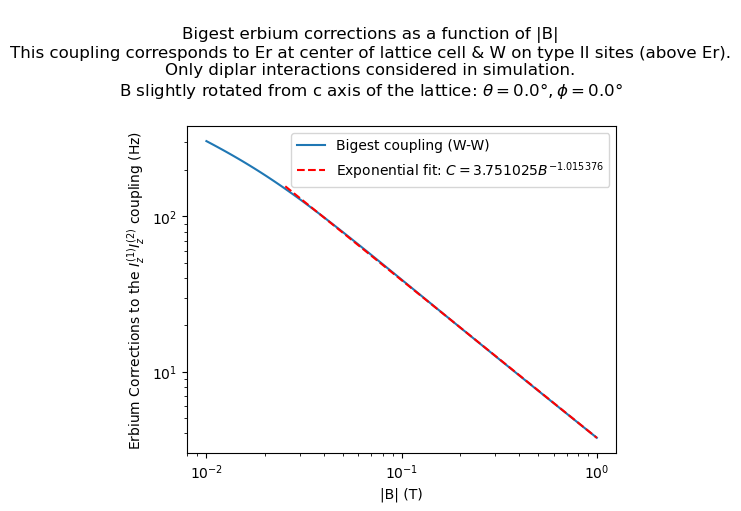

In [52]:
fig, ax = plt.subplots(1,figsize=(5, 5), constrained_layout=True)
fig.suptitle(f"""
Bigest erbium corrections as a function of |B|
This coupling corresponds to Er at center of lattice cell & W on type II sites (above Er).
Only diplar interactions considered in simulation.
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
""")
ax.set_xlabel("|B| (T)")
ax.set_ylabel(r"Erbium Corrections to the $I_z^{(1)}I_z^{(2)}$ coupling (Hz)")
ax.loglog(B_fields, corrections, label="Bigest coupling (W-W)")

p = np.polyfit(np.log(B_fields[20:]), np.log(corrections[20:]), 1)

ax.loglog(B_fields[20:], np.exp(p[1] + p[0]*np.log(B_fields[20:])), label=f"Exponential fit: $C={{{np.exp(p[1]):f}}}B^{{{p[0]:f}}}$", linestyle="dashed", color="red")

ax.legend()

pass

In [53]:
# B field misalignment
theta = 0/180*np.pi
phi = 0/180*np.pi

B_fields = np.logspace(-1, 0, 100)
corrections = np.empty((len(B_fields), len(full_H_sites)))
no_er_couplings = np.empty((len(B_fields), len(full_H_sites)))
with_er_couplings = np.empty((len(B_fields), len(full_H_sites)))

for i, b in enumerate(B_fields):
    coupling, _, _, _, no_er_coupling = get_energies(b, 0.45, 0.45, theta, phi, first_cell_sites)
    corrections[i] = coupling - no_er_coupling
    no_er_couplings[i] = no_er_coupling
    with_er_couplings[i] = coupling

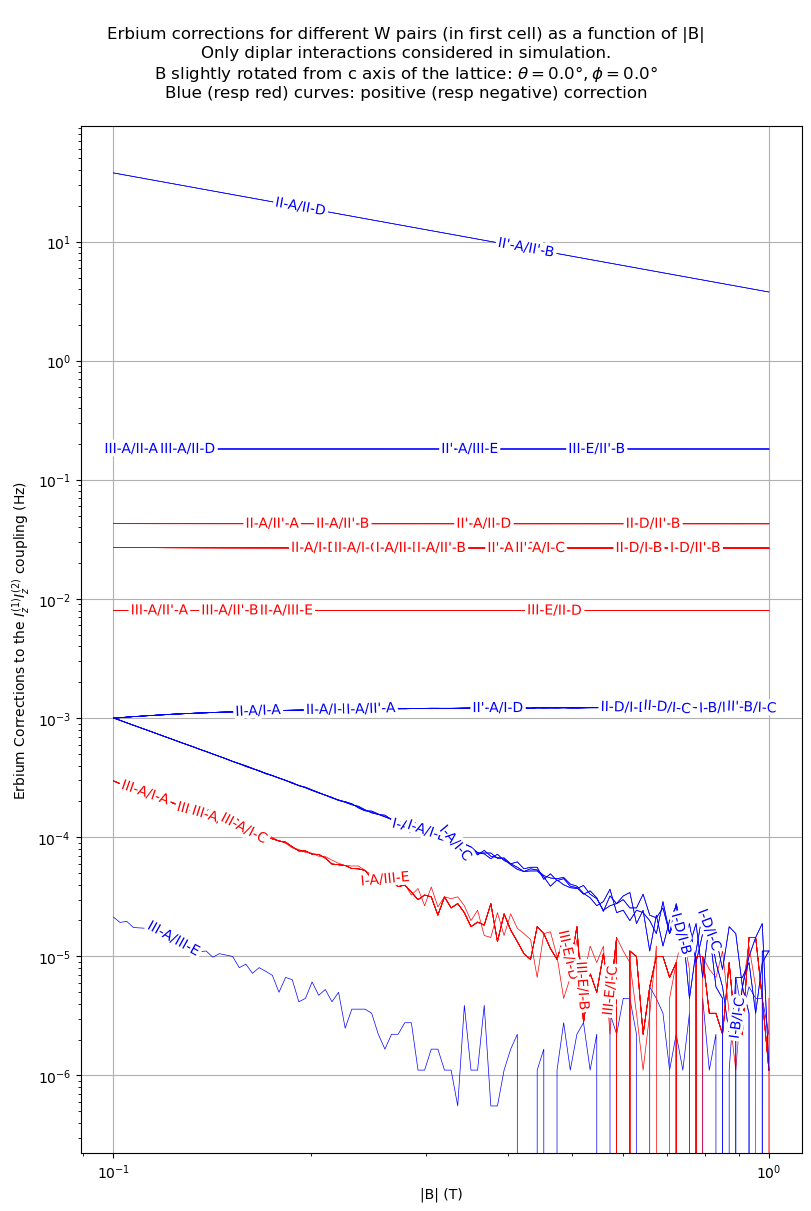

In [54]:
fig, ax = plt.subplots(1,figsize=(8, 12), constrained_layout=True)
fig.suptitle(f"""
Erbium corrections for different W pairs (in first cell) as a function of |B|
Only diplar interactions considered in simulation.
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
Blue (resp red) curves: positive (resp negative) correction
""")
ax.set_xlabel("|B| (T)")
ax.set_ylabel(r"Erbium Corrections to the $I_z^{(1)}I_z^{(2)}$ coupling (Hz)")
for i in range(corrections.shape[1]):
    was_positive = corrections[0,i] >= 0
    color = "blue" if was_positive else "red"
    ax.loglog(B_fields, np.abs(corrections[:,i]), linewidth=0.5, color=color, label = f"{first_cell_label(full_H_sites[i,0])}/{first_cell_label(full_H_sites[i,1])}")

labelLines(ax.get_lines(), zorder=2.5)
ax.grid()

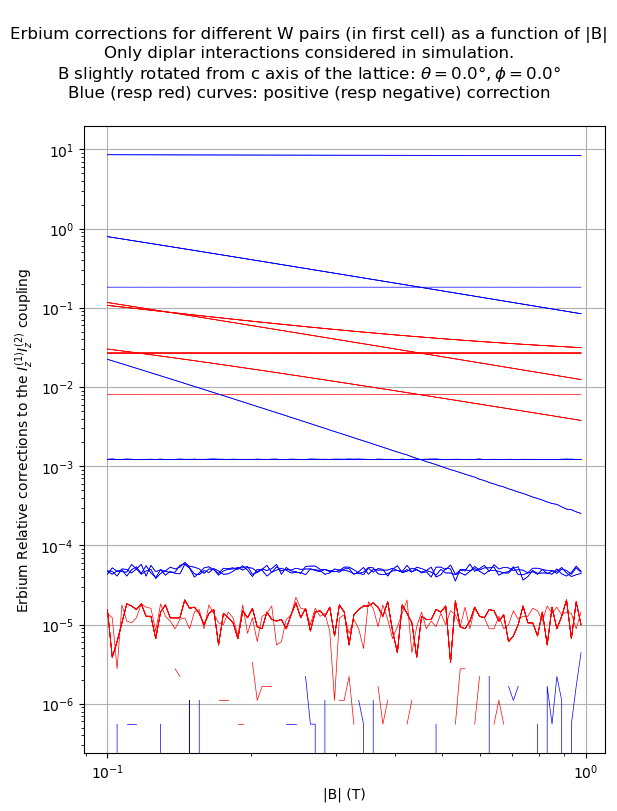

In [21]:
fig, ax = plt.subplots(1,figsize=(6, 8), constrained_layout=True)
fig.suptitle(f"""
Erbium corrections for different W pairs (in first cell) as a function of |B|
Only diplar interactions considered in simulation.
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
Blue (resp red) curves: positive (resp negative) correction
""")
ax.set_xlabel("|B| (T)")
ax.set_ylabel(r"Erbium Relative corrections to the $I_z^{(1)}I_z^{(2)}$ coupling")

for i in range(corrections.shape[1]):
    was_positive = corrections[0,i] >= 0
    current_segment_x = [B_fields[0]]
    current_segment_y = [corrections[0,i]]
    for j in range(1, len(B_fields)):
        
        if was_positive != (corrections[j,i] >= 0) or j == len(B_fields) - 1:
            color = "blue" if was_positive else "red"
            ax.loglog(np.array(current_segment_x), np.abs(np.array(current_segment_y)), linewidth=0.5, color=color)
            was_positive = corrections[j,i] >= 0
            current_segment_x = [B_fields[j]]
            current_segment_y = [corrections[j,i]]
        else:
            current_segment_x.append(B_fields[j])
            current_segment_y.append(corrections[j,i])
            

ax.grid()

In [22]:
# B field misalignment
theta = 0/180*np.pi
phi = 0/180*np.pi

B_fields = np.logspace(-1.9, 0, 300)
relative_corrections = np.empty((len(B_fields), len(full_H_sites)))

for i, b in enumerate(B_fields):
    coupling, _, _, _, no_er_coupling = get_energies(b, b, b, theta, phi, first_cell_sites)
    relative_corrections[i] = (coupling - no_er_coupling)/no_er_coupling

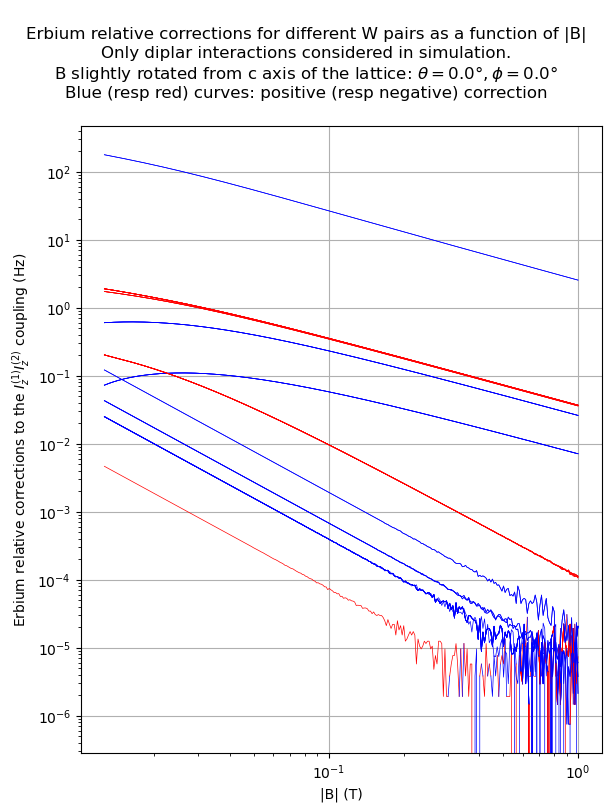

In [23]:
fig, ax = plt.subplots(1,figsize=(6, 8), constrained_layout=True)
fig.suptitle(f"""
Erbium relative corrections for different W pairs as a function of |B|
Only diplar interactions considered in simulation.
B slightly rotated from c axis of the lattice: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$
Blue (resp red) curves: positive (resp negative) correction
""")
ax.set_xlabel("|B| (T)")
ax.set_ylabel(r"Erbium relative corrections to the $I_z^{(1)}I_z^{(2)}$ coupling (Hz)")

for i in range(relative_corrections.shape[1]):
    was_positive = relative_corrections[0,i] >= 0
    current_segment_x = [B_fields[0]]
    current_segment_y = [relative_corrections[0,i]]
    for j in range(1, len(B_fields)):
        current_segment_x.append(B_fields[j])
        current_segment_y.append(relative_corrections[j,i])
        if was_positive != (relative_corrections[j,i] >= 0) or j == len(B_fields) - 1:
            color = "blue" if was_positive else "red"
            ax.loglog(np.array(current_segment_x), np.abs(np.array(current_segment_y)), linewidth=0.5, color=color)
            was_positive = relative_corrections[j,i] >= 0
            current_segment_x = [B_fields[j]]
            current_segment_y = [relative_corrections[j,i]]
            

ax.grid()

# Analysis

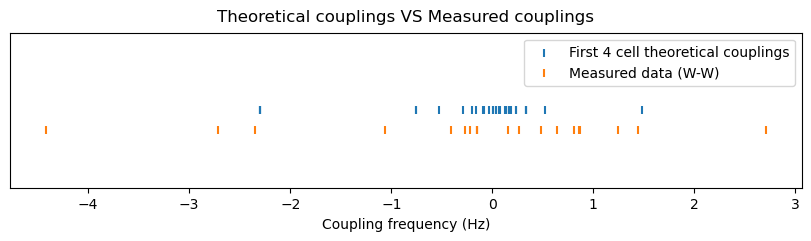

In [24]:
fig, ax = plt.subplots(1,figsize=(8, 2.3), constrained_layout=True)
fig.suptitle("Theoretical couplings VS Measured couplings")
ax.set_xlabel("Coupling frequency (Hz)")

one_cell_couplings = couplings(cell_sites)

theo_data = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)])
ax.scatter(theo_data, np.zeros(theo_data.shape)+1, marker = "|", label="First 4 cell theoretical couplings")

measured_data = (renormalized_data[1:,:])[~np.isnan(renormalized_data[1:,:])]
ax.scatter(measured_data, np.zeros(measured_data.shape), marker = "|", label="Measured data (W-W)")
ax.set_ylim((-3,5))
ax.legend()
ax.get_yaxis().set_ticks([])

pass

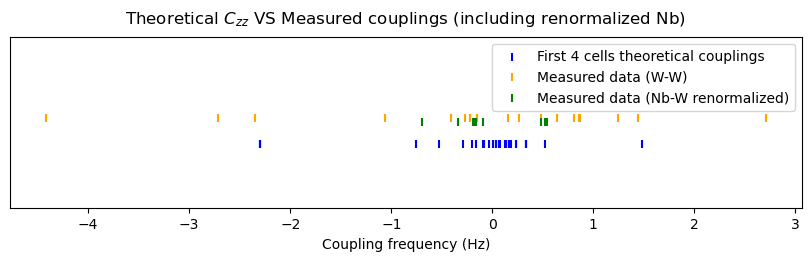

In [25]:
fig, ax = plt.subplots(1,figsize=(8, 2.5), constrained_layout=True)
fig.suptitle("Theoretical $C_{zz}$ VS Measured couplings (including renormalized Nb)")
ax.set_xlabel("Coupling frequency (Hz)")
ax.set_ylim((-3,5))

one_cell_couplings = couplings(cell_sites)

theo_data = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)])
ax.scatter(theo_data, np.zeros(theo_data.shape), marker = "|", label="First 4 cells theoretical couplings", color="blue")

measured_data = (renormalized_data[1:,:])[~np.isnan(renormalized_data[1:,:])]
ax.scatter(measured_data, np.zeros(measured_data.shape)+1.2, marker = "|", label="Measured data (W-W)", color="orange")

measured_data = renormalized_data[0,:]
ax.scatter(measured_data, np.zeros(measured_data.shape)+1, marker = "|", label="Measured data (Nb-W renormalized)", color="green")

ax.legend()
ax.get_yaxis().set_ticks([])

pass

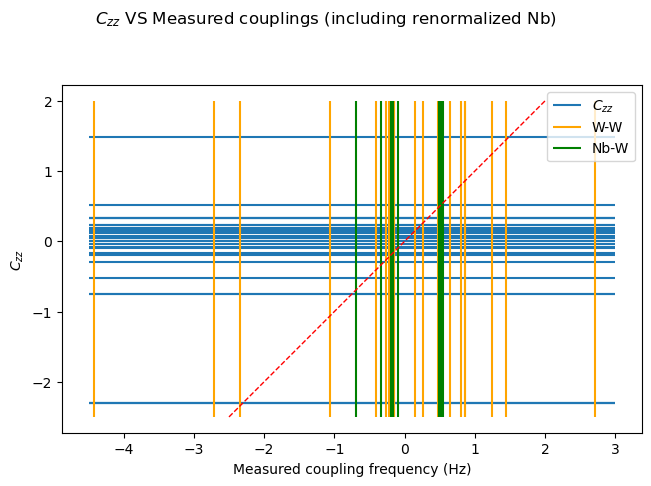

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
fig.suptitle("$C_{zz}$ VS Measured couplings (including renormalized Nb)")
ax.set_xlabel("Measured coupling frequency (Hz)")
ax.set_ylabel("$C_{zz}$")

one_cell_couplings = couplings(cell_sites)

theo_data = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)])

measured_data_nb = renormalized_data[0,:]

measured_data = (renormalized_data[1:,:])[~np.isnan(renormalized_data[1:,:])]

ax.hlines(theo_data,-4.5,3, label="$C_{zz}$")
ax.vlines(measured_data,-2.5,2, color="orange", label="W-W")
ax.vlines(measured_data_nb,-2.5,2, color="green", label="Nb-W")

ax.plot([-2.5,2], [-2.5,2], linestyle="--", color = "red", linewidth = 1)
ax.set_aspect(1)
ax.legend()

pass

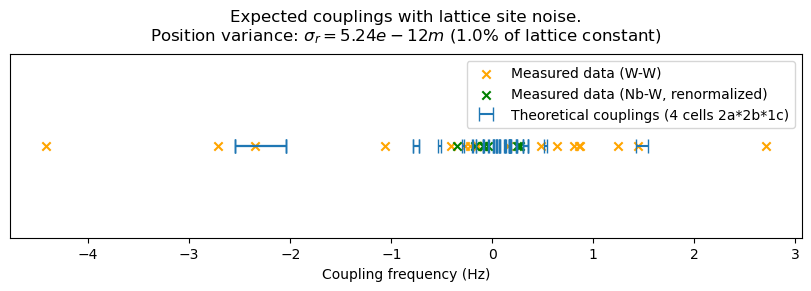

In [27]:
fig, ax = plt.subplots(figsize=(8, 2.8), constrained_layout=True)
ax.set_xlabel("Coupling frequency (Hz)")

one_cell_couplings = couplings(cell_sites)

# Noisy data generation
error_sigma =  0.01*a
noisy = positions[None,:,:] + np.random.normal(loc=0, scale = error_sigma, size=(10000,positions.shape[0],positions.shape[1]))
one_cell_err = np.std(np.array([spatial_couplings(n) for n in noisy]),axis=0)


fig.suptitle(f"Expected couplings with lattice site noise.\nPosition variance: $\\sigma_{{r}} = {error_sigma:.2e} m $ ({error_sigma/a*100}% of lattice constant)")


# Remove nan values for display
data, indices = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)], return_index = True)
xerr_noise = one_cell_err[~np.isnan(one_cell_couplings)][indices]

ax.errorbar(data, np.zeros(data.shape), xerr=xerr_noise, capsize=5, linestyle='',marker = "", label="Theoretical couplings (4 cells 2a*2b*1c)")


measured_data = (renormalized_data[1:,:])[~np.isnan(renormalized_data[1:,:])]
ax.scatter(measured_data, np.zeros(measured_data.shape), marker = "x", label="Measured data (W-W)", color="orange")


measured_data = (renormalized_data[0,:])[~np.isnan(renormalized_data[0,:])]/2
ax.scatter(measured_data, np.zeros(measured_data.shape), marker = "x", label="Measured data (Nb-W, renormalized)", color="green")

ax.legend()
ax.get_yaxis().set_ticks([])


pass

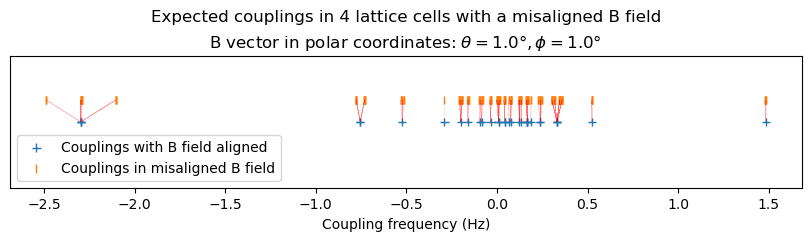

In [28]:
fig, ax = plt.subplots(1,figsize=(8, 2.3), constrained_layout=True)
fig.suptitle("Expected couplings in 4 lattice cells with a misaligned B field")
ax.set_xlabel("Coupling frequency (Hz)")
ax.set_ylim((-3,3))

one_cell_couplings = couplings(cell_sites)

theta = 1 * (np.pi / 180)
phi = 1 * (np.pi / 180)


ax.set_title(f"B vector in polar coordinates: $\\theta = {theta * 180 / np.pi}°, \\phi = {phi * 180 / np.pi}°$")

rotation = Rotation.from_rotvec(-theta * np.array([np.cos(phi), np.sin(phi), 0])) # Minus is here in order to rotate B field
rotated_positions = rotation.apply(positions)
rotated_couplings = spatial_couplings(rotated_positions)

# Remove nan values for display
data, inverse = np.unique(one_cell_couplings[~np.isnan(one_cell_couplings)], return_inverse = True)
rotated_data, index = np.unique(rotated_couplings[~np.isnan(rotated_couplings)], return_index = True)


ax.scatter(data, np.zeros(data.shape), linestyle='',marker = "+", label="Couplings with B field aligned")
ax.scatter(rotated_data, np.zeros(rotated_data.shape)+1, linestyle='',marker = "|", label=f"Couplings in misaligned B field")


for i, j in enumerate(index):
    ax.plot([data[inverse[j]],rotated_data[i]], [0,1], linestyle="--", color = "red", linewidth = 0.1)

ax.legend()
ax.get_yaxis().set_ticks([])

pass

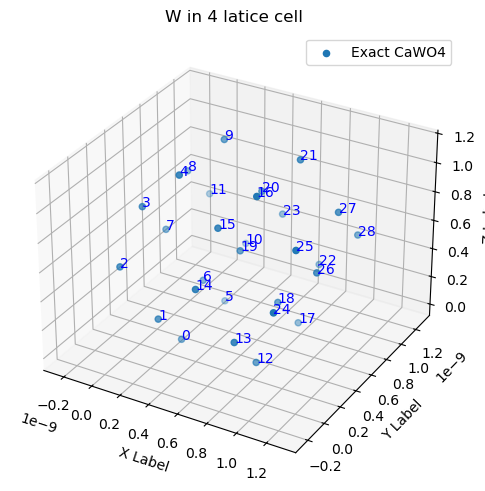

In [29]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection='3d')

max_index = cell_sites.shape[0]
positions = lattice_x[None,:]*cell_sites[:max_index,0][:,None] + lattice_y[None,:] * cell_sites[:max_index,1][:,None] + lattice_z[None,:] * cell_sites[:max_index,2][:,None] + lattice_s[cell_sites[:max_index,3]]

ax.scatter(positions[:,0], positions[:,1], positions[:,2], label="Exact CaWO4")


# Noisy data generation
error_sigma =  0.05*a

fig.suptitle("W in 4 latice cell")
noisy = positions + np.random.normal(loc=0, scale = error_sigma, size=(max_index, 3))


#ax.scatter(noisy[:,0], noisy[:,1], noisy[:,2], label=f"Noisy (Variance = {error_sigma/a*100}% of lattice constant)")

#ax.scatter(rotated_positions[:max_index,0], rotated_positions[:max_index,1], rotated_positions[:max_index,2], label=f"Rotated positions")



for i in range(max_index):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')
ax.legend()



In [30]:
# B field misalignment
theta = 1/180*np.pi
phi = 1/180*np.pi


B_0 = 0.45  # T

full_H_couplings, full_H_positions, full_H_eigv, full_H_sites = get_A_parallel(B_0, theta, phi, eight_cell_sites)

In [31]:
np.sort(full_H_couplings)

array([-6.52209383e+04, -2.24070215e+04, -2.22570870e+04, -2.22570870e+04,
       -2.09098425e+04, -8.15865421e+03, -5.04400638e+03, -4.97531239e+03,
       -3.81618250e+03, -3.78275585e+03, -2.80279205e+03, -2.66369960e+03,
       -2.64237292e+03, -2.61549588e+03, -2.40242483e+03, -1.58241140e+03,
       -1.52047667e+03, -1.51086538e+03, -1.45126930e+03, -1.43027569e+03,
       -1.11341207e+03, -1.10282277e+03, -1.02365263e+03, -9.94569245e+02,
       -9.83471401e+02, -8.73465606e+02, -8.34184922e+02, -8.30465118e+02,
       -8.24349965e+02, -7.16774909e+02, -6.87997982e+02, -6.71062294e+02,
       -6.30502154e+02, -5.02712797e+02, -4.45318591e+02, -3.20959782e+01,
        3.78702589e+02,  1.48747755e+03,  1.84105801e+03,  2.39850246e+03,
        2.42745025e+03,  2.57156160e+03,  3.53348411e+03,  3.53661314e+03,
        3.65295626e+03,  3.65608531e+03,  6.30459639e+03,  9.37540321e+03,
        9.47893675e+03,  2.05654119e+04,  4.01417474e+04,  4.01417474e+04,
        4.02008741e+04,  